In [ ]:
# Colab Cell 1: Library Imports and Configuration
!pip install rapidfuzz
# =============================================================================
# 1. Configuration and Library Imports
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from rapidfuzz import process, fuzz # Ensure rapidfuzz is installed: !pip install rapidfuzz
from collections import defaultdict
import plotly.express as px # Ensure plotly is installed: !pip install plotly
import matplotlib.dates as mdates

# Professional plotting style
sns.set(style='whitegrid')

# Suppress warnings for cleaner output during execution
import warnings
warnings.filterwarnings('ignore')

# Define file paths (Adjust if your files are in Google Drive, e.g., /content/drive/MyDrive/...)
SALES_DATA_PATH = 'sales data for analysis.csv'
CREDIT_DATA_PATH = 'credit data for analysis.csv'

print("Libraries imported and configuration set.")

Libraries imported and configuration set.


In [ ]:
# Colab Cell 2: Data Loading, Initial Cleaning, Preprocessing, and Feature Engineering

# =============================================================================
# 2. Data Loading
# =============================================================================
def load_data(sales_path, credit_path):
    """
    Loads sales and credit datasets from specified paths.
    Prints initial shapes and a sample of each dataset.
    """
    sales_df = pd.read_csv(sales_path)
    credit_df = pd.read_csv(credit_path)

    print("Sales Data Shape (Raw):", sales_df.shape)
    print("Credit Data Shape (Raw):", credit_df.shape)
    print("\nSales Data Sample (Raw):\n", sales_df.head(2))
    print("\nCredit Data Sample (Raw):\n", credit_df.head(2))
    return sales_df, credit_df

# =============================================================================
# 3. Data Cleaning Pipeline
# =============================================================================
def clean_and_convert_columns(raw_df, currency_cols=[], date_col='Date'):
    """
    Cleans column names, currency columns, and dates in a DataFrame.
    """
    df = raw_df.copy()
    df.columns = df.columns.str.strip()

    # Clean currency columns and convert to float
    for col in currency_cols:
        if col in df.columns:
            # Handle potential non-string values before .str accessor
            df[col] = df[col].astype(str)\
                             .str.replace(r'[₹,]', '', regex=True)\
                             .astype(float)

    # Convert dates
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    return df

def clean_customer_names_fuzzy(df_sales, df_credit):
    """
    Cleans customer names in both sales and credit DataFrames using fuzzy matching.
    Returns DataFrames with a new 'Customer Name Clean' column.
    """
    sales_df_cleaned = df_sales.copy()
    credit_df_cleaned = df_credit.copy()

    # Basic name cleanup (uppercase and strip whitespace)
    sales_df_cleaned['Customer Name'] = sales_df_cleaned['Customer Name'].str.upper().str.strip()
    credit_df_cleaned['Customer Name'] = credit_df_cleaned['Customer Name'].str.upper().str.strip()

    # Get unique names from sales for clustering (as sales drives primary customer records)
    unique_names = sales_df_cleaned['Customer Name'].unique()

    # Build clusters based on fuzzy similarity
    clusters = defaultdict(list)
    processed = set()

    for name in unique_names:
        if name in processed:
            continue
        # Use a high similarity threshold (e.g., 90) for strong matches
        matches = process.extract(name, unique_names, scorer=fuzz.token_sort_ratio, limit=None)
        root = name # The current name becomes the root for its cluster
        for match_name, score, _ in matches:
            if score >= 90 and match_name not in processed:
                clusters[root].append(match_name)
                processed.add(match_name)

    # Create a single mapping from all variants to their chosen root name
    final_mapping = {}
    for root, variants in clusters.items():
        for v in variants:
            final_mapping[v] = root

    # Apply mapping to both sales and credit DataFrames
    sales_df_cleaned['Customer Name Clean'] = sales_df_cleaned['Customer Name'].map(final_mapping)
    credit_df_cleaned['Customer Name Clean'] = credit_df_cleaned['Customer Name'].map(final_mapping)

    return sales_df_cleaned, credit_df_cleaned

# =============================================================================
# 4. Data Preprocessing and Feature Engineering
# =============================================================================
def preprocess_sales_data(df):
    """
    Adds 'Margin' calculation, 'Month' and 'Product weight' column to sales data.
    """
    sales_df_processed = df.copy()

    def calculate_margin(row):
        base_margin = 0
        # Ensure 'Weight(in gm.)' and 'Rate /gm' are numeric and not NaN
        if pd.notna(row.get('Weight(in gm.)')) and pd.notna(row.get('Rate /gm')):
            if row['Category'].lower() == 'gold':
                base_margin = 0.10 * row['Weight(in gm.)'] * row['Rate /gm']
            elif row['Category'].lower() == 'silver':
                base_margin = 0.20 * row['Weight(in gm.)'] * row['Rate /gm']
            # Add other categories here if needed
        else:
            # If weight or rate is missing, base margin is 0
            base_margin = 0

        # Ensure 'Making/Labour charges' and 'Discount' exist and are numeric (or 0)
        making_labour_charges = row.get('Making/Labour charges', 0.0)
        discount = row.get('Discount', 0.0)

        # Ensure these are floats before arithmetic, handle NaN if any slipped
        making_labour_charges = making_labour_charges if pd.notna(making_labour_charges) else 0.0
        discount = discount if pd.notna(discount) else 0.0

        margin = base_margin + making_labour_charges - discount
        return margin

    sales_df_processed['Margin_₹'] = sales_df_processed.apply(calculate_margin, axis=1)

    # Convert 'Date' to a Period for correct monthly sorting if needed for some plots
    sales_df_processed['Month'] = sales_df_processed['Date'].dt.to_period('M').astype(str)

    # Calculate 'Product weight' as total weight sold per transaction
    sales_df_processed['Product_Total_Weight_gm'] = sales_df_processed['Weight(in gm.)']

    return sales_df_processed

def preprocess_credit_data(df):
    """
    Adds 'Month', 'Year', 'Payment_Month', and 'Season' columns to credit data.
    Uses 'Date' as the date column for credit_df.
    """
    credit_df_processed = df.copy()
    # Corrected: Using 'Date' column for credit_df
    credit_df_processed['Month'] = credit_df_processed['Date'].dt.month
    credit_df_processed['Year'] = credit_df_processed['Date'].dt.year
    credit_df_processed['Payment_Month'] = credit_df_processed['Date'].dt.month_name()

    def assign_season(month):
        if month in [4, 5, 6]:
            return 'Rabi Harvest'
        elif month in [7, 8, 9]:
            return 'Zaid'
        elif month in [10, 11]:
            return 'Kharif Harvest'
        elif month in [12, 1, 2, 3]:
            return 'Rabi Sowing/Lean'
        else:
            return 'Other' # For any month not falling into these categories

    credit_df_processed['Season'] = credit_df_processed['Month'].apply(assign_season)
    return credit_df_processed

# =============================================================================
# Execute Data Loading, Cleaning, and Preprocessing
# =============================================================================

# 1. Load data
sales_df_raw, credit_df_raw = load_data(SALES_DATA_PATH, CREDIT_DATA_PATH)

# 2. Apply initial cleaning (currency and dates)
sales_df = clean_and_convert_columns(
    sales_df_raw,
    currency_cols=["Making/Labour charges", "Discount", "Total Amount(₹)", "Exchange Value (₹)"],
    date_col='Date'
)
# Corrected: Using 'Date' for credit_df date_col
credit_df = clean_and_convert_columns(
    credit_df_raw,
    currency_cols=["Amount paid by customer(₹)"],
    date_col='Date'
)
print("\nInitial data cleaning (currency and dates) applied.")

# 3. Clean customer names using fuzzy matching
sales_df, credit_df = clean_customer_names_fuzzy(sales_df, credit_df)
print("Customer names cleaned and mapped across both dataframes.")

# 4. Feature Engineering for sales data
sales_df = preprocess_sales_data(sales_df)
print("Sales data preprocessed (Margin, Month, Product_Total_Weight_gm added).")

# 5. Feature Engineering for credit data
credit_df = preprocess_credit_data(credit_df) # This function now correctly uses 'Date' internally
print("Credit data preprocessed (Month, Year, Payment_Month, Season added).")

print("\nAll data loading, cleaning, and preprocessing steps completed. DataFrames are ready for analysis.")

# Display a sample of processed dataframes
print("\nSales Data Sample (Processed):\n", sales_df.head(2))
print("\nCredit Data Sample (Processed):\n", credit_df.head(2))

Sales Data Shape (Raw): (985, 14)
Credit Data Shape (Raw): (296, 3)

Sales Data Sample (Raw):
   Customer Name        Date Product name Category   Weight(in gm.)  Rate /gm  \
0     SHERSINGH  09/12/2020         RING      GOLD             2.6    5100.0   
1    SHYAM BABU  09/12/2020       ANKLET    SILVER            50.0      62.0   

  Diffrence  Making/Labour charges Discount  Total Amount(₹) Payment Type\t  \
0      ₹0.00                 ₹0.00    ₹0.00       ₹13,260.00           Full   
1    ₹100.00               ₹100.00    ₹0.00        ₹3,200.00           Full   

   Number of Payments Exchange Used Exchange Value (₹)          
0                   0            No                      ₹0.00  
1                   0            No                      ₹0.00  

Credit Data Sample (Raw):
    Customer Name        Date Amount paid by customer(₹)
0          UMESH  30/05/2020                   1,500.00
1  RAMOTAR JATAV  14/10/2020                   1,000.00

Initial data cleaning (currency an

In [ ]:
# Colab Cell 3: Descriptive Statistics and KPI Analysis

# =============================================================================
# 5. Descriptive Statistics and KPI Analysis
# =============================================================================

print("--- Descriptive Statistics by Category ---")
category_stats = sales_df.groupby('Category').agg(
    Transaction_Count=('Total Amount(₹)', 'count'),
    Mean_Value=('Total Amount(₹)', 'mean'),
    Median_Value=('Total Amount(₹)', 'median'),
    Value_Range=('Total Amount(₹)', lambda x: x.max() - x.min())
).reset_index()
display(category_stats)

print("\n--- KPI Analysis: Average Transaction Value & Best-Sellers ---")

# Average Transaction Value (ATV) by category
category_kpi = sales_df.groupby('Category').agg(
    Total_Revenue=('Total Amount(₹)', 'sum'),
    Transaction_Count=('Total Amount(₹)', 'count')
)
category_kpi['ATV'] = category_kpi['Total_Revenue'] / category_kpi['Transaction_Count']
print("\nAverage Transaction Value by Category:")
display(category_kpi[['ATV']])

# Best-selling products (filtering out those with <5 sales)
product_counts = sales_df['Product name'].value_counts()
# Ensure 'popular_products' is available globally for later cells if needed
global popular_products
popular_products = product_counts[product_counts >= 5].index.tolist()

global best_sellers
best_sellers = sales_df[sales_df['Product name'].isin(popular_products)]\
    .groupby('Product name').agg(
        Total_Revenue=('Total Amount(₹)', 'sum'),
        Units_Sold=('Product name', 'count')
    ).sort_values('Total_Revenue', ascending=False)
print("\nBest-selling products (only products with 5 or more sales):")
display(best_sellers)

print("Descriptive statistics and KPI analysis completed.")

--- Descriptive Statistics by Category ---


,Category,Transaction_Count,Mean_Value,Median_Value,Value_Range
0,GOLD,391,9548.537084,7400.0,80050.0
1,SILVER,594,4232.616162,3600.0,21200.0



--- KPI Analysis: Average Transaction Value & Best-Sellers ---

Average Transaction Value by Category:


,ATV
Category,
GOLD,9548.537084
SILVER,4232.616162



Best-selling products (only products with 5 or more sales):


,Total_Revenue,Units_Sold
Product name,,
ANKLET,2068337.0,444
EARRINGS,1175575.0,131
JHUMKI,629931.0,26
PENDANT,306950.0,34
5 PENDANT SET,284500.0,13
RING,237910.0,26
CHAIN,229587.0,23
NECKLACE,227050.0,7
BANGLE,216180.0,50


Descriptive statistics and KPI analysis completed.


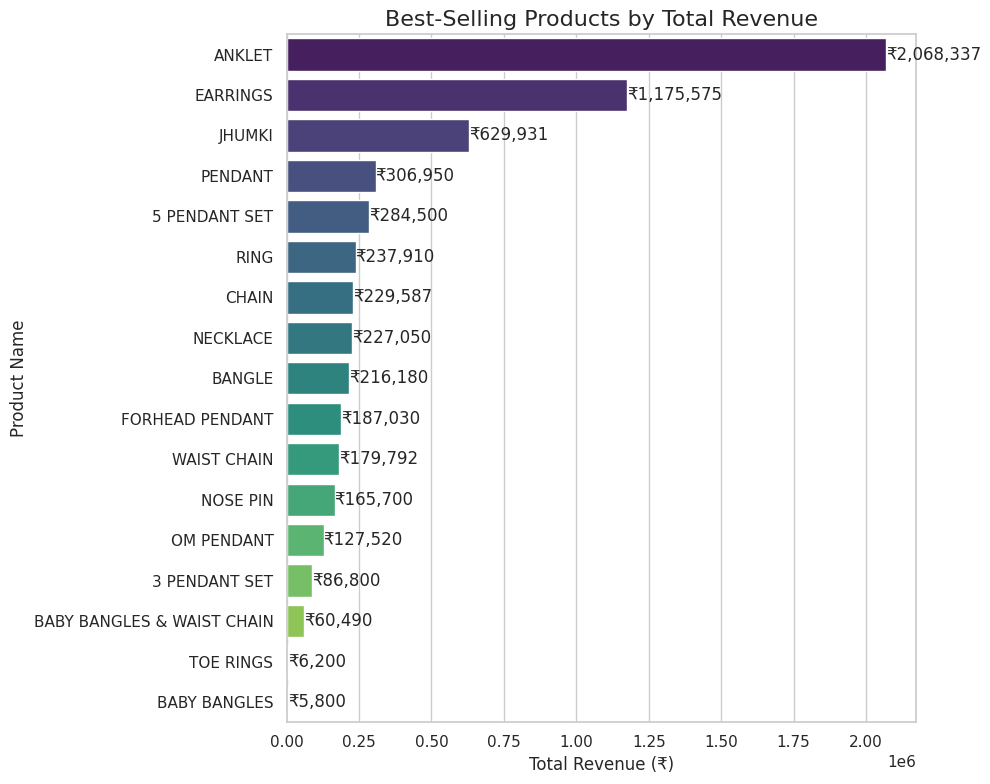

Best-Selling Products chart generated.


In [ ]:
# Colab Cell 4: Visualization: Best-Selling Products

# =============================================================================
# 6. Visualization: Best-Selling Products
# =============================================================================
plt.figure(figsize=(10, 8))
sns.barplot(
    y=best_sellers.index,
    x=best_sellers['Total_Revenue'],
    palette='viridis'
)
# Add revenue values on bars for clarity
for index, value in enumerate(best_sellers['Total_Revenue']):
    plt.text(value, index, f'₹{value:,.0f}', va='center')

plt.title('Best-Selling Products by Total Revenue', fontsize=16)
plt.xlabel('Total Revenue (₹)')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

print("Best-Selling Products chart generated.")

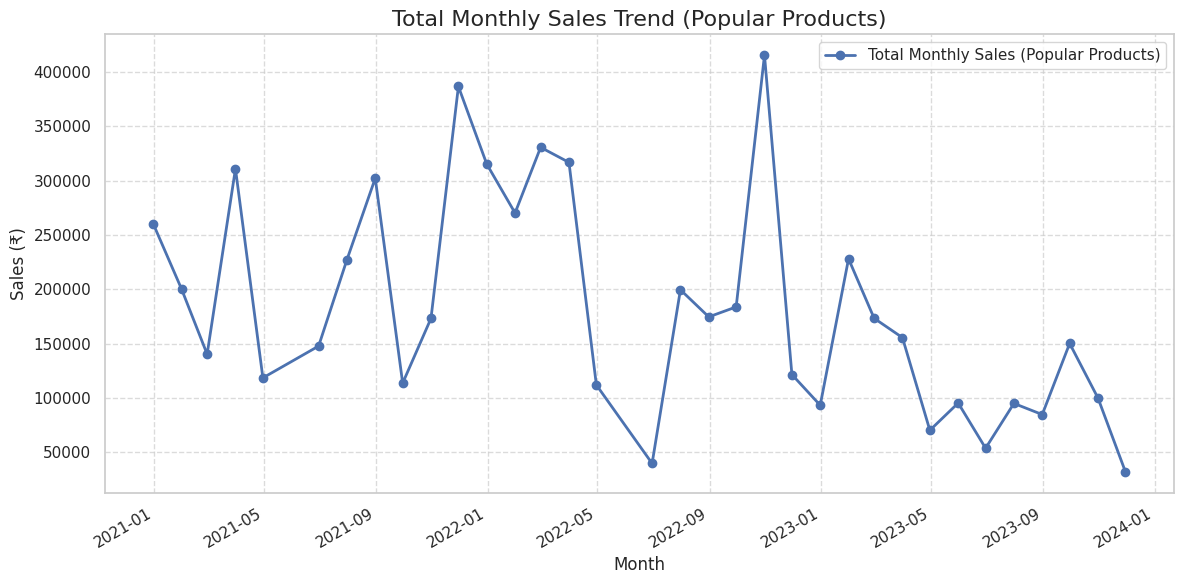

Monthly Sales Trend chart generated.


In [ ]:
# Colab Cell 5: Trend Analysis: Monthly Sales of Popular Products

# =============================================================================
# 7. Trend Analysis: Monthly Sales by Product
# =============================================================================
# Group by month and product, then unstack to get product sales per month
monthly_sales_by_product = sales_df.set_index('Date')\
    .groupby([pd.Grouper(freq='M'), 'Product name'])['Total Amount(₹)'].sum()\
    .unstack(fill_value=0)

# Filter for only the popular products identified earlier
if 'popular_products' in globals(): # Check if it exists from previous cell
    monthly_sales_popular = monthly_sales_by_product[popular_products]
else:
    print("Warning: 'popular_products' not found. This plot might not be accurate.")
    monthly_sales_popular = monthly_sales_by_product # Use all if popular products not defined

# Plot total monthly sales of all popular products
plt.figure(figsize=(12, 6))
monthly_sales_popular.sum(axis=1).plot(label='Total Monthly Sales (Popular Products)', lw=2, marker='o')
plt.title('Total Monthly Sales Trend (Popular Products)', fontsize=16)
plt.ylabel('Sales (₹)')
plt.xlabel('Month')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Monthly Sales Trend chart generated.")

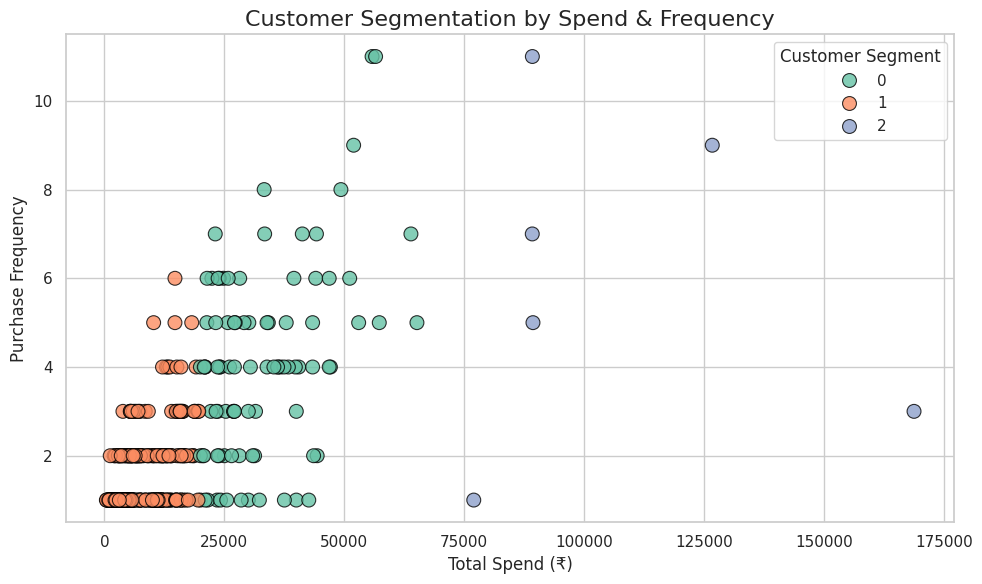

Customer Segmentation chart generated.


In [ ]:
# Colab Cell 6: Customer Profiling & Segmentation

# =============================================================================
# 8. Customer Profiling & Segmentation
# =============================================================================
from sklearn.cluster import KMeans

customer_profiles = sales_df.groupby('Customer Name Clean').agg(
    Total_Spend=('Total Amount(₹)', 'sum'),
    Purchase_Frequency=('Product name', 'count'),
    Category_Variety=('Category', 'nunique')
)

# Prepare data for clustering - only using numerical features for KMeans
X = customer_profiles[['Total_Spend', 'Purchase_Frequency']]

# Determine optimal number of clusters (e.g., using Elbow Method)
# For simplicity, we'll stick to n_clusters=3 as in your original code
# If you want to run Elbow Method:
# inertia = []
# for n in range(1, 11):
#     kmeans = KMeans(n_clusters=n, random_state=42, n_init='auto')
#     kmeans.fit(X)
#     inertia.append(kmeans.inertia_)
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, 11), inertia, marker='o')
# plt.title('Elbow Method for Optimal K')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Inertia')
# plt.show()


kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto') # Added n_init='auto'
customer_profiles['Segment'] = kmeans.fit_predict(X)

# Visualize customer segments
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Total_Spend', y='Purchase_Frequency',
    hue='Segment', data=customer_profiles,
    palette='Set2', s=100, edgecolor='black', alpha=0.8
)
plt.title('Customer Segmentation by Spend & Frequency', fontsize=16)
plt.xlabel('Total Spend (₹)')
plt.ylabel('Purchase Frequency')
plt.legend(title='Customer Segment')
plt.tight_layout()
plt.show()

print("Customer Segmentation chart generated.")

In [ ]:
# Colab Cell 7: Product Demand and Sales Trends: Sunburst Chart

# =============================================================================
# 9. Product Demand and Sales Trends: Sunburst Chart
# =============================================================================
import plotly.express as px

sunburst_data = sales_df.groupby(['Category', 'Product name']).size().reset_index(name='Units_Sold')
fig = px.sunburst(
    sunburst_data,
    path=['Category', 'Product name'],
    values='Units_Sold',
    color='Units_Sold',
    color_continuous_scale='viridis',
    title='Product Category & Demand Hierarchy (Units Sold)'
)
fig.show()

print("Product Category and Demand Hierarchy (Sunburst Chart) generated.")

Product Category and Demand Hierarchy (Sunburst Chart) generated.


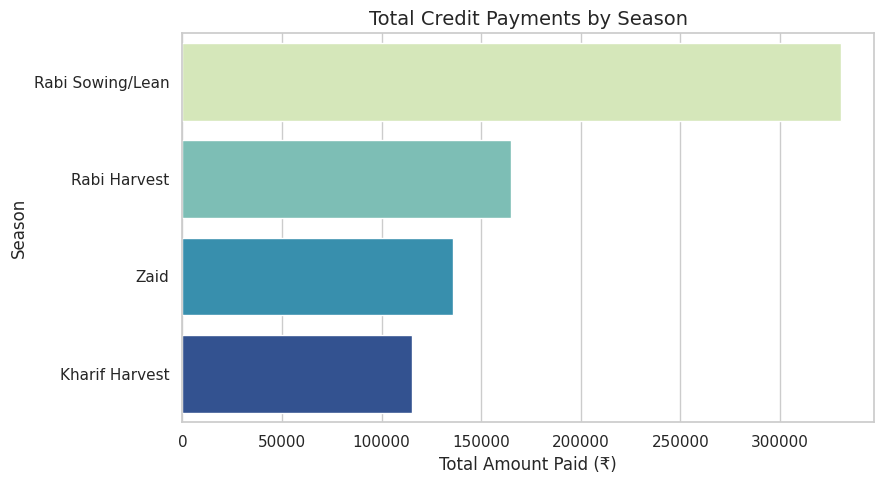

Total Credit Payments by Season chart generated.


In [ ]:
# Colab Cell 8: Credit Payment Analysis: Total Credit Payments by Season

# =============================================================================
# 10. Credit Payment Analysis: Total Credit Payments by Season
# =============================================================================
# Aggregate for bar chart
seasonal_payments = credit_df.groupby('Season')['Amount paid by customer(₹)'].agg(['sum', 'count']).reset_index()

# Sort by total payments in descending order
seasonal_payments = seasonal_payments.sort_values(by='sum', ascending=False)

plt.figure(figsize=(9, 5))
sns.barplot(x='sum', y='Season', data=seasonal_payments, palette='YlGnBu')
plt.title('Total Credit Payments by Season', fontsize=14)
plt.xlabel('Total Amount Paid (₹)')
plt.ylabel('Season')
plt.tight_layout()
plt.show()

print("Total Credit Payments by Season chart generated.")

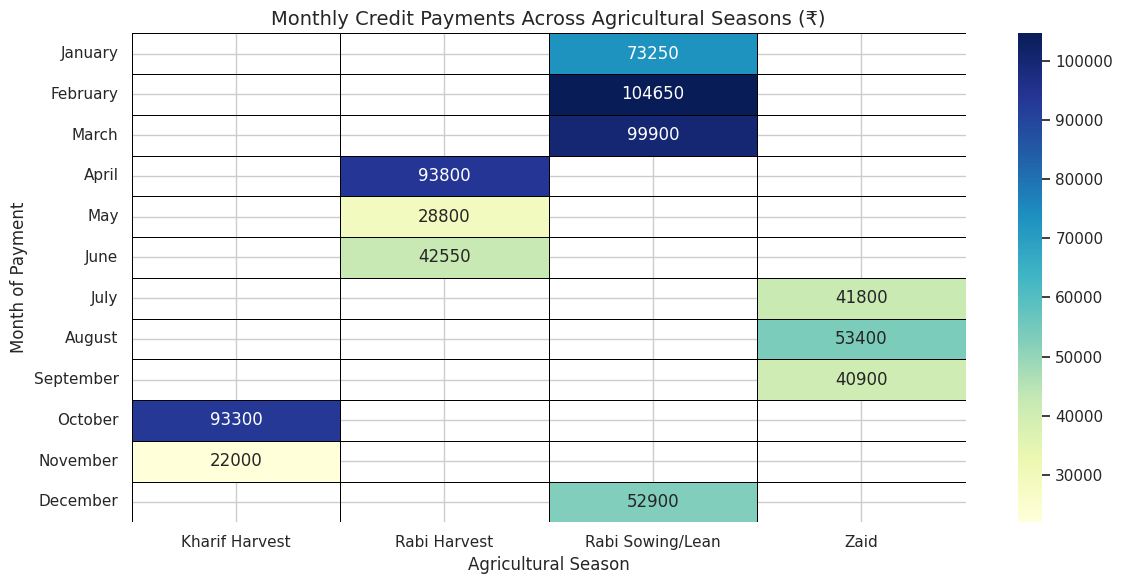

Monthly Credit Payments Heatmap generated.


In [ ]:
# Colab Cell 9: Credit Payment Analysis: Monthly Credit Payments Heatmap

# =============================================================================
# 11. Credit Payment Analysis: Monthly Credit Payments Across Agricultural Seasons
# =============================================================================
# Month order for proper sorting on the Y-axis
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']

# Create a cross-tabulation (pivot table) for the heatmap
pivot = pd.crosstab(
    credit_df['Payment_Month'],
    credit_df['Season'],
    values=credit_df['Amount paid by customer(₹)'],
    aggfunc='sum'
).reindex(month_order) # Reindex to ensure correct month order

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=0.5, linecolor='black') # Added linecolor for better separation
plt.title('Monthly Credit Payments Across Agricultural Seasons (₹)', fontsize=14)
plt.xlabel('Agricultural Season')
plt.ylabel('Month of Payment')
plt.tight_layout()
plt.show()

print("Monthly Credit Payments Heatmap generated.")

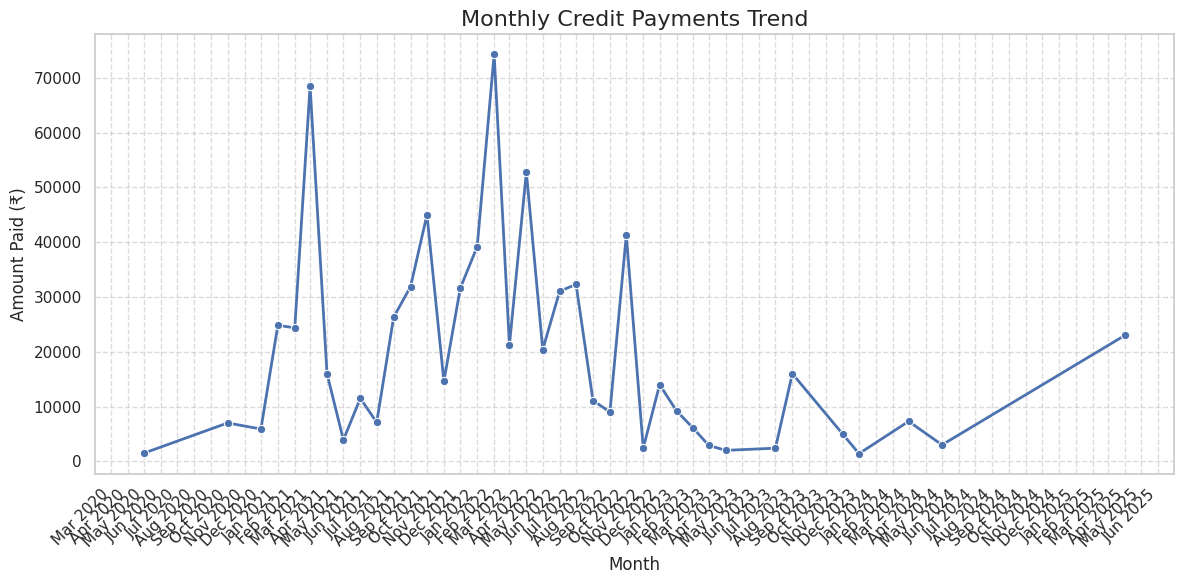

Monthly Credit Payments Trend chart generated.

Delayed Payment Behavior analysis chart generated.

--- Credit Payment Analysis: Delayed Payment Behavior ---


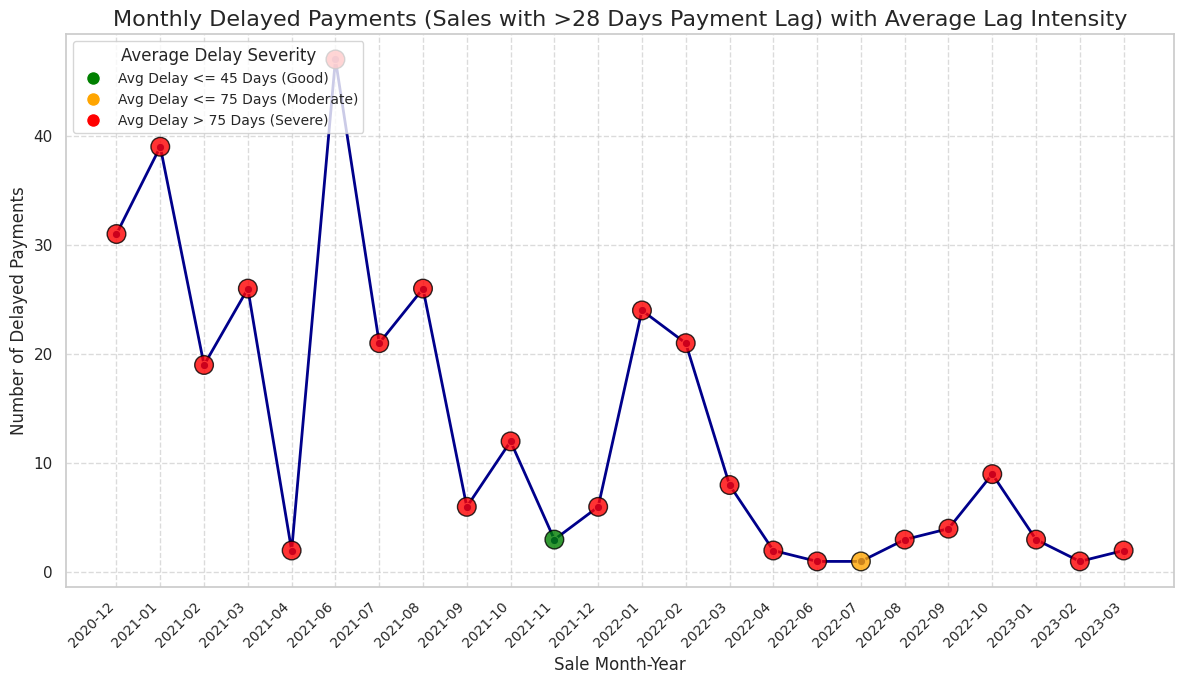

In [ ]:
# Colab Cell 10: Monthly Credit Payments Trend & Delayed Payments Analysis

# =============================================================================
# 12. Credit Payment Analysis: Monthly Credit Payments Trend
# =============================================================================
# Group by year and month to get monthly total payments
monthly_credit_trend = credit_df.groupby(['Year', 'Month'])['Amount paid by customer(₹)'].sum().reset_index()

# Create a datetime object for plotting
monthly_credit_trend['Date_For_Plot'] = pd.to_datetime(monthly_credit_trend[['Year', 'Month']].assign(day=1))

plt.figure(figsize=(12,6))
sns.lineplot(x='Date_For_Plot', y='Amount paid by customer(₹)', data=monthly_credit_trend, marker='o', lw=2)

plt.title('Monthly Credit Payments Trend', fontsize=16)
plt.ylabel('Amount Paid (₹)')
plt.xlabel('Month')

# Format x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Show every month
plt.xticks(rotation=45, ha='right') # Rotate and align labels
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Monthly Credit Payments Trend chart generated.")


# =============================================================================
# 13. Credit Payment Analysis: Delayed Payment Behavior
# =============================================================================

# Function definition (already provided and corrected in previous response,
# included here for completeness of the cell)
def analyze_delayed_payments(sales_df_cleaned, credit_df_cleaned):
    """
    Analyzes and visualizes monthly delayed payments, highlighting intensity.
    Corrected to use 'Date' column for credit_df's payment date.
    """
    print("\n--- Credit Payment Analysis: Delayed Payment Behavior ---")
    # Merge sales and credit data based on cleaned customer names and dates
    # Renaming credit_df's 'Date' column to 'Payment_Date' for clarity in merge
    merged_df = pd.merge(
        sales_df_cleaned[['Customer Name Clean', 'Date']], # Sale Date from sales_df
        credit_df_cleaned[['Customer Name Clean', 'Date']].rename(columns={'Date': 'Payment_Date'}), # Payment Date from credit_df
        on='Customer Name Clean',
        how='inner'
    )

    # Keep only payments that occurred on or after the sale date
    # This filter is crucial to ensure we're looking at payments for *past* sales
    merged_df = merged_df[merged_df['Payment_Date'] >= merged_df['Date']]

    # Calculate delay in days
    merged_df['Days_Delayed'] = (merged_df['Payment_Date'] - merged_df['Date']).dt.days
    # Define 'delayed' as payment taking longer than 28 days (approx 4 weeks)
    merged_df['Is_Delayed'] = merged_df['Days_Delayed'] > 28
    # Get Month-Year of the *sale* date for trend analysis of delayed payments
    merged_df['Sale_Month_Year'] = merged_df['Date'].dt.to_period('M').astype(str)

    # Aggregate summary for delayed payments
    # Only consider records where payment was actually delayed
    delay_summary = merged_df[merged_df['Is_Delayed']].groupby('Sale_Month_Year').agg(
        Delayed_Payments_Count=('Is_Delayed', 'sum'), # Count of True values (delayed payments)
        Avg_Days_Delayed=('Days_Delayed', 'mean') # Average delay in days for those delayed
    ).reset_index()

    # Ensure chronological order for plotting
    delay_summary['Sale_Month_Year_Sort'] = pd.to_datetime(delay_summary['Sale_Month_Year'])
    delay_summary = delay_summary.sort_values('Sale_Month_Year_Sort').drop(columns='Sale_Month_Year_Sort')


    # Plot the trend of delayed payments
    plt.figure(figsize=(12,7))
    sns.lineplot(x='Sale_Month_Year', y='Delayed_Payments_Count', data=delay_summary, marker='o', lw=2, color='darkblue')

    # Color code points by delay intensity (Avg_Days_Delayed)
    # Using a diverging colormap or specific colors to indicate severity
    colors = delay_summary['Avg_Days_Delayed'].apply(
        lambda x: 'green' if x <= 45 else ('orange' if x <= 75 else 'red') # Green (good), Orange (moderate), Red (severe)
    )

    # Overlay scatter points with colors indicating severity
    plt.scatter(
        delay_summary['Sale_Month_Year'],
        delay_summary['Delayed_Payments_Count'],
        c=colors, s=180, alpha=0.8, edgecolor='black', zorder=5 # zorder to ensure points are on top
    )

    plt.title('Monthly Delayed Payments (Sales with >28 Days Payment Lag) with Average Lag Intensity', fontsize=16)
    plt.xlabel('Sale Month-Year', fontsize=12)
    plt.ylabel('Number of Delayed Payments', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Create a custom legend for the color intensity
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Avg Delay <= 45 Days (Good)', markerfacecolor='green', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Avg Delay <= 75 Days (Moderate)', markerfacecolor='orange', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Avg Delay > 75 Days (Severe)', markerfacecolor='red', markersize=10)
    ]
    plt.legend(handles=legend_elements, loc='upper left', title="Average Delay Severity", fontsize=10)

    plt.tight_layout()
    plt.show()

print("\nDelayed Payment Behavior analysis chart generated.")

# Call the function to execute the plot
analyze_delayed_payments(sales_df, credit_df)

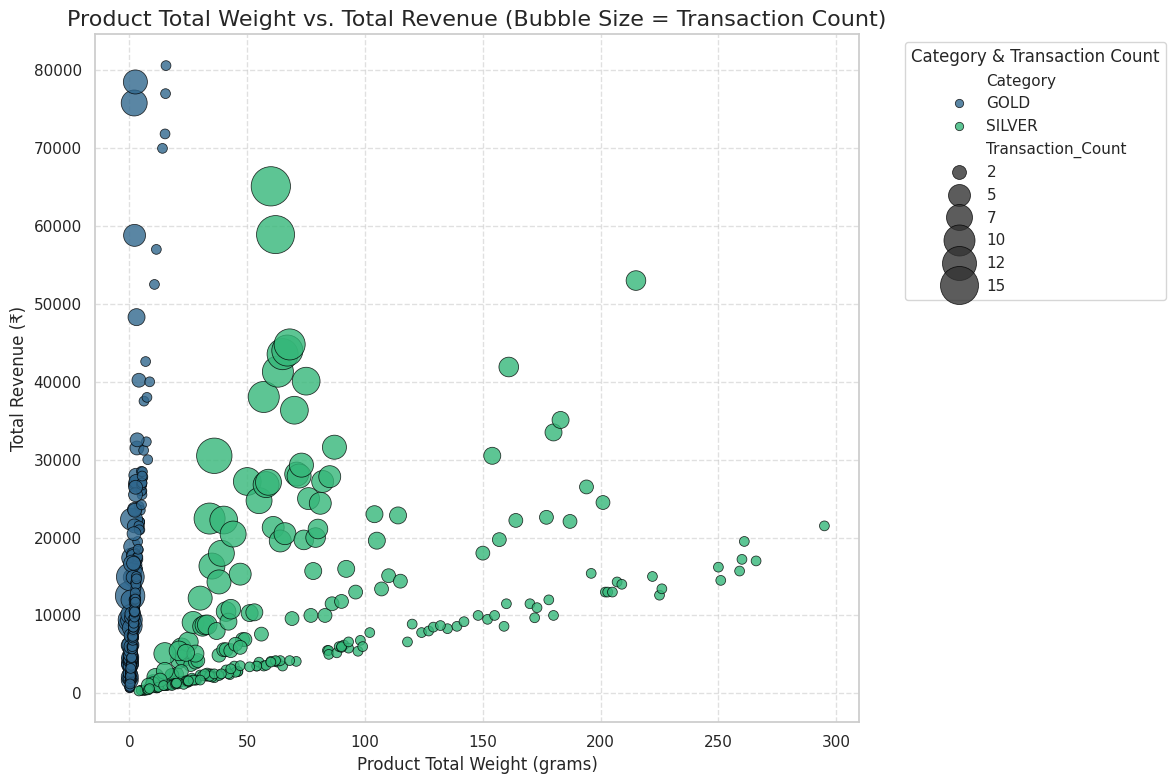

Product Weight vs. Revenue Scatterplot generated.


In [ ]:
# Colab Cell 11: Product Weight vs. Revenue Scatterplot

# =============================================================================
# 13. Product Weight vs. Revenue Scatterplot
# =============================================================================
# Calculate the data for the scatter plot
weight_analysis = sales_df.groupby(['Product name', 'Category', 'Product_Total_Weight_gm']).agg(
    Total_Revenue=('Total Amount(₹)', 'sum'),
    Transaction_Count=('Total Amount(₹)', 'count')
).reset_index()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=weight_analysis,
                x='Product_Total_Weight_gm', y='Total_Revenue',
                hue='Category', size='Transaction_Count', # Bubble size represents transaction count
                sizes=(50, 800), # Adjust min/max bubble size for better visual
                palette='viridis', alpha=0.8, edgecolor='black') # Added edgecolor for better visibility

plt.title('Product Total Weight vs. Total Revenue (Bubble Size = Transaction Count)', fontsize=16)
plt.xlabel('Product Total Weight (grams)')
plt.ylabel('Total Revenue (₹)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Category & Transaction Count') # Clarify legend title
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Product Weight vs. Revenue Scatterplot generated.")

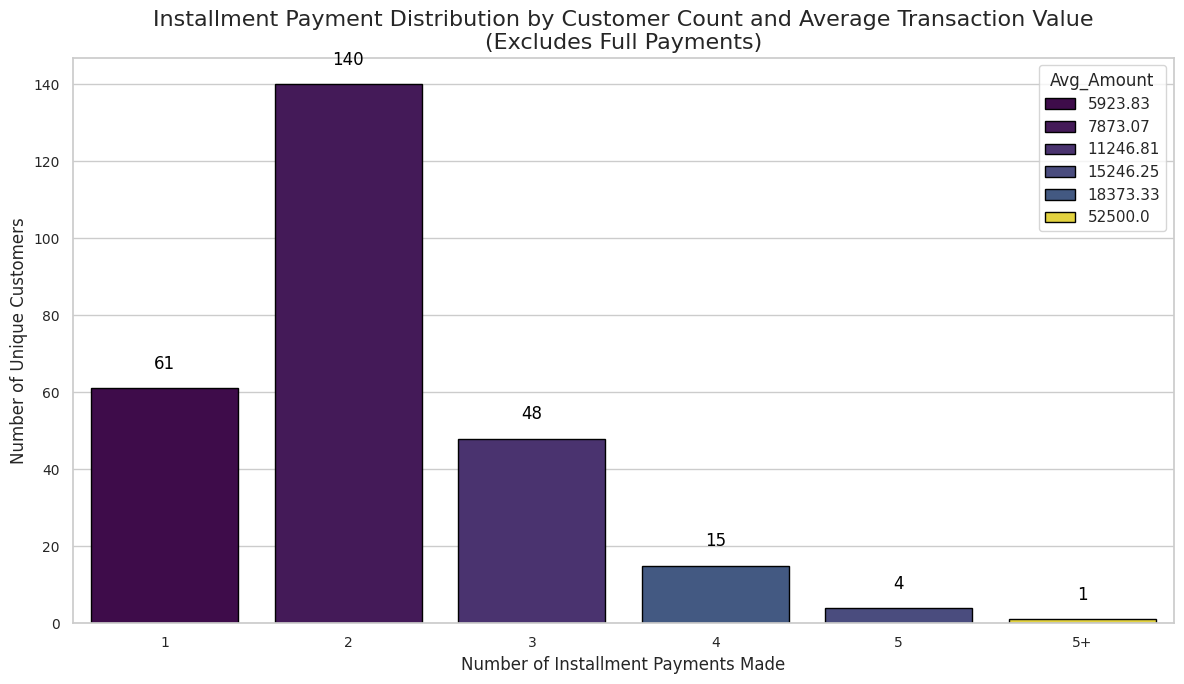

Installment Payment Behavior chart generated.


In [ ]:
# Colab Cell 12: Installment Payment Behavior

# =============================================================================
# 14. Installment Payment Behavior
# =============================================================================
# Filter out customers who paid in full (0 installments)
installment_df = sales_df[sales_df['Number of Payments'] > 0].copy() # Use .copy() to avoid SettingWithCopyWarning

# Bin payment counts: Group payments >5 into a '5+' category for cleaner visualization
installment_df['Payment Bin'] = installment_df['Number of Payments'].apply(
    lambda x: str(int(x)) if x <= 5 else '5+'
)

# Aggregate data by Payment Bin
payment_analysis = installment_df.groupby('Payment Bin').agg(
    Total_Customers=('Customer Name Clean', 'nunique'), # Use cleaned name for unique customer count
    Avg_Amount=('Total Amount(₹)', 'mean')
).reset_index()

# Sort Payment Bins correctly for plotting (especially '5+')
# Define a custom sort order
sort_order = [str(i) for i in range(1, 6)] + ['5+']
payment_analysis['Payment Bin'] = pd.Categorical(payment_analysis['Payment Bin'], categories=sort_order, ordered=True)
payment_analysis = payment_analysis.sort_values('Payment Bin')

payment_analysis['Avg_Amount'] = payment_analysis['Avg_Amount'].round(2)

# Plot
plt.figure(figsize=(12,7))
# Use 'Total_Customers' for y-axis and 'Avg_Amount' for color gradient to show correlation
sns.barplot(
    x='Payment Bin',
    y='Total_Customers',
    hue='Avg_Amount', # Color by Average Amount for that payment bin
    data=payment_analysis,
    palette='viridis', # Choose a sequential colormap
    dodge=False, # Ensures bars are not dodged if hue is used, one bar per x-value
    edgecolor='black'
)

# Add text labels for Total_Customers on top of bars
for index, row in payment_analysis.iterrows():
    plt.text(index, row['Total_Customers'] + 5, # Adjust offset for text
             f'{int(row["Total_Customers"])}',
             color='black', ha="center")

# --- REMOVED THE FOLLOWING LINE THAT CAUSED THE ERROR ---
# plt.colorbar(ax=plt.gca().collections[0], label='Average Transaction Value (₹)')

plt.title('Installment Payment Distribution by Customer Count and Average Transaction Value\n(Excludes Full Payments)', fontsize=16)
plt.ylabel('Number of Unique Customers', fontsize=12)
plt.xlabel('Number of Installment Payments Made', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

print("Installment Payment Behavior chart generated.")

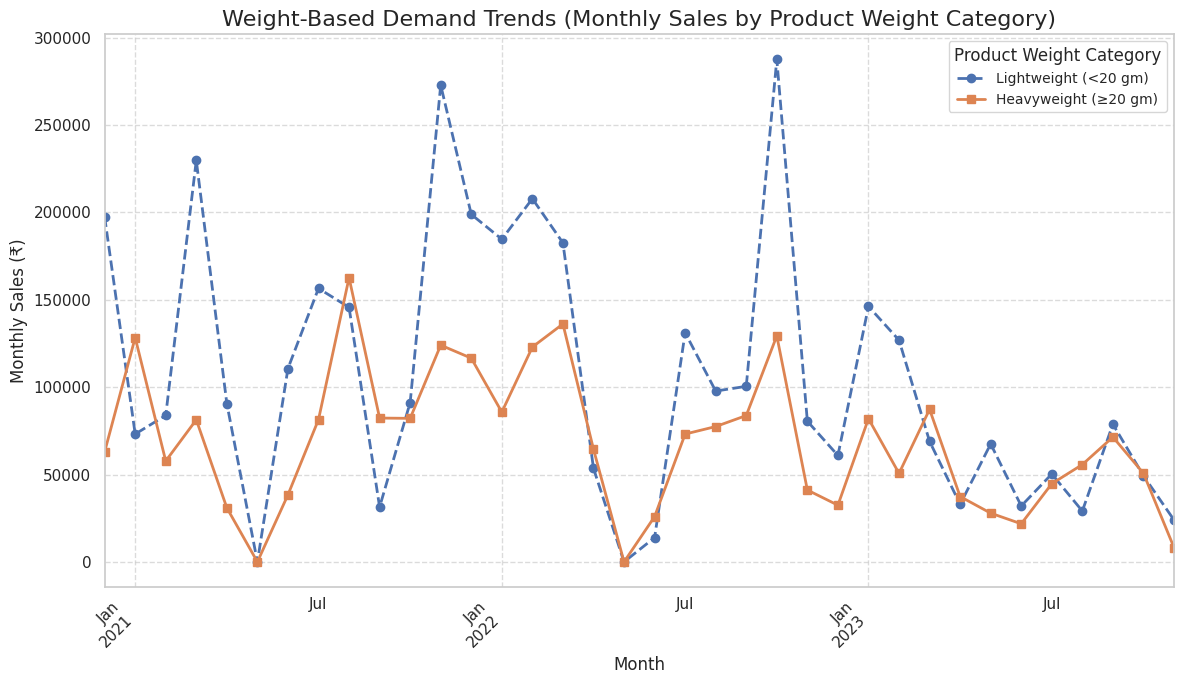

Weight-Based Demand Trends chart generated.


In [ ]:
# Colab Cell 13: Weight-Based Demand Trends

# =============================================================================
# 15. Weight-Based Demand Trends
# =============================================================================
# Define a more realistic threshold for 'light' vs. 'heavy' based on typical jewelry weights.
# You might need to adjust this threshold (e.g., 50g, 100g, 200g) after inspecting `sales_df['Product_Total_Weight_gm'].describe()`.
# Let's use a dynamic threshold like the median or 75th percentile if no domain knowledge.
weight_median = sales_df['Product_Total_Weight_gm'].median()
# For demonstration, let's set a fixed threshold, e.g., 50 grams for jewelry
weight_threshold = 20 # grams

light_products_sales = sales_df[sales_df['Product_Total_Weight_gm'] < weight_threshold]
heavy_products_sales = sales_df[sales_df['Product_Total_Weight_gm'] >= weight_threshold]

plt.figure(figsize=(12,7))
# Group by Date (monthly frequency) and sum Total Amount for each category
light_products_sales.set_index('Date')['Total Amount(₹)'].resample('M').sum().plot(
    label=f'Lightweight (<{weight_threshold} gm)', linestyle='--', marker='o', lw=2)
heavy_products_sales.set_index('Date')['Total Amount(₹)'].resample('M').sum().plot(
    label=f'Heavyweight (≥{weight_threshold} gm)', linestyle='-', marker='s', lw=2)

plt.title('Weight-Based Demand Trends (Monthly Sales by Product Weight Category)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Monthly Sales (₹)', fontsize=12)
plt.legend(title='Product Weight Category', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Weight-Based Demand Trends chart generated.")

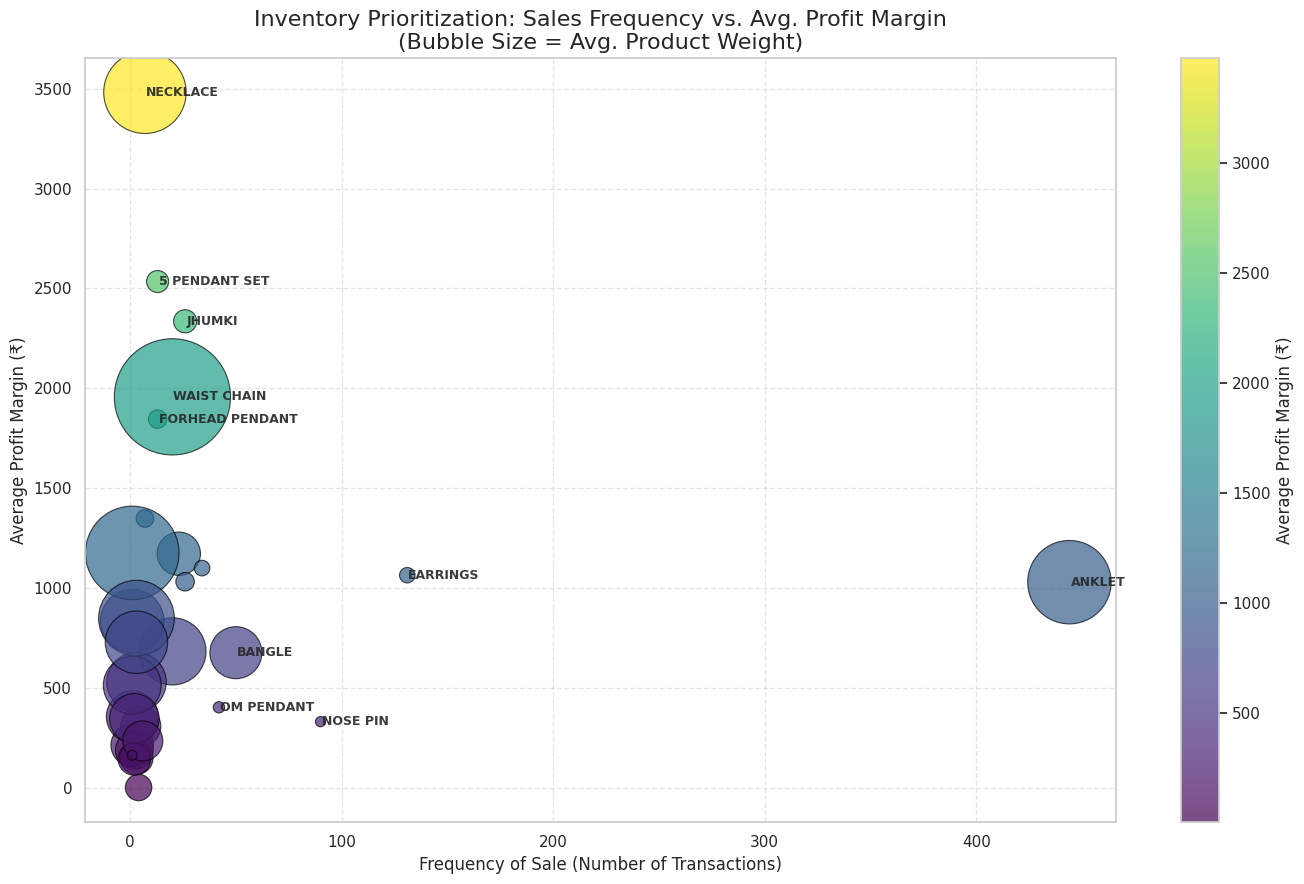

Inventory Prioritization Bubble Chart generated.


In [ ]:
# Colab Cell 14: Inventory Prioritization Bubble Chart

# =============================================================================
# 16. Inventory Optimization: Prioritization Bubble Chart
# =============================================================================

# Aggregate sales data per product for the bubble chart
inventory_data = sales_df.groupby('Product name').agg(
    Frequency_of_Sale=('Product name', 'count'), # How many times a product was sold
    Avg_Profit_Margin=('Margin_₹', 'mean'), # Average margin generated per sale of this product
    # Using 'Product_Total_Weight_gm' mean as a proxy for 'size' or 'value density' of the product.
    # If you had actual 'Current Stock' and 'Sales Volume' columns, you'd calculate turnover rate differently.
    # For now, let's rename it to 'Avg_Product_Weight' for clarity as a bubble size driver.
    Avg_Product_Weight=('Product_Total_Weight_gm', 'mean')
).reset_index()

# Handle potential NaNs in Avg_Profit_Margin or Avg_Product_Weight
inventory_data['Avg_Profit_Margin'] = inventory_data['Avg_Profit_Margin'].fillna(0)
inventory_data['Avg_Product_Weight'] = inventory_data['Avg_Product_Weight'].fillna(inventory_data['Avg_Product_Weight'].mean()) # Fill with mean or median

# Scale bubble sizes for better visualization, based on Avg_Product_Weight
# Adding a small constant (+1) to avoid zero or negative sizes if min is 0 or negative
sizes = (inventory_data['Avg_Product_Weight'] - inventory_data['Avg_Product_Weight'].min() + 1) * 50
# Clamp sizes to a reasonable range if needed, e.g., sizes = np.clip(sizes, 50, 1000)

plt.figure(figsize=(14, 9)) # Increased figure size for better readability
scatter = plt.scatter(
    inventory_data['Frequency_of_Sale'],
    inventory_data['Avg_Profit_Margin'],
    s=sizes, # Bubble size based on average product weight
    alpha=0.7,
    c=inventory_data['Avg_Profit_Margin'],  # Color by Average Profit Margin
    cmap='viridis', # Colormap for the profit margin
    edgecolor='black',
    linewidth=0.8
)

plt.colorbar(scatter, label='Average Profit Margin (₹)')
plt.xlabel('Frequency of Sale (Number of Transactions)', fontsize=12)
plt.ylabel('Average Profit Margin (₹)', fontsize=12)
plt.title('Inventory Prioritization: Sales Frequency vs. Avg. Profit Margin\n(Bubble Size = Avg. Product Weight)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate top products to highlight them
# Define thresholds for 'high value' products for annotation
threshold_margin = inventory_data['Avg_Profit_Margin'].quantile(0.85) # Top 15% by margin
threshold_freq = inventory_data['Frequency_of_Sale'].quantile(0.85) # Top 15% by frequency

# Annotate products that are high in either margin or frequency
for _, row in inventory_data.iterrows():
    if row['Avg_Profit_Margin'] > threshold_margin or row['Frequency_of_Sale'] > threshold_freq:
        plt.text(
            row['Frequency_of_Sale'] + 0.5, # Adjust x-offset
            row['Avg_Profit_Margin'],
            row['Product name'],
            fontsize=9,
            weight='bold',
            alpha=0.9,
            ha='left', # Horizontal alignment
            va='center' # Vertical alignment
        )

plt.tight_layout()
plt.show()

print("Inventory Prioritization Bubble Chart generated.")

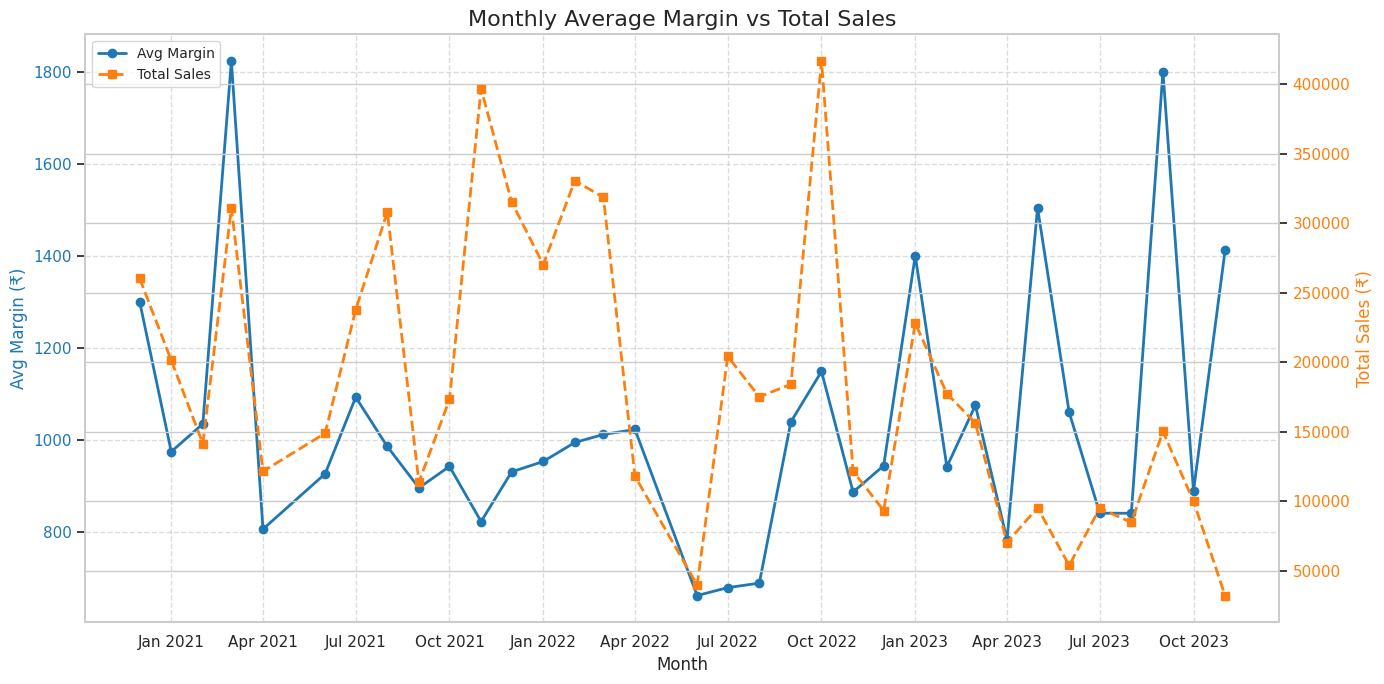

Monthly Average Margin vs Total Sales chart generated.


In [ ]:
# Colab Cell 15: Monthly Average Margin vs Total Sales

# =============================================================================
# 17. Monthly Average Margin vs Total Sales
# =============================================================================
monthly_summary = sales_df.groupby('Month').agg(
    Avg_Margin=('Margin_₹', 'mean'),
    Total_Sales=('Total Amount(₹)', 'sum')
).reset_index()

# Ensure chronological sorting for monthly data
# Convert 'Month' to datetime objects for proper sorting and plotting
monthly_summary['Month_Sort'] = pd.to_datetime(monthly_summary['Month'])
# IMPORTANT: DO NOT DROP 'Month_Sort' here. We need it for plotting!
monthly_summary = monthly_summary.sort_values('Month_Sort') # Keep 'Month_Sort'


fig, ax1 = plt.subplots(figsize=(14,7)) # Increased figure width for more space

# Plot Average Margin on primary Y-axis
color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Avg Margin (₹)', color=color, fontsize=12)
# Plot using 'Month_Sort' column
ax1.plot(monthly_summary['Month_Sort'], monthly_summary['Avg_Margin'], marker='o', color=color, lw=2, label='Avg Margin')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7) # Add grid for primary axis

# Create a twin Y-axis for Total Sales
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Total Sales (₹)', color=color, fontsize=12)
# Plot using 'Month_Sort' column
ax2.plot(monthly_summary['Month_Sort'], monthly_summary['Total_Sales'], marker='s', linestyle='--', color=color, lw=2, label='Total Sales')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10)

# --- Start of X-axis improvement ---
# Use matplotlib.dates for better date formatting and control
import matplotlib.dates as mdates

# Set major ticks to show every 3 months, for example
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Show tick every 3 months
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) # Format as 'Jan 2023'

# Rotate labels and align them
plt.xticks(rotation=45, ha='right', fontsize=10) # Keep rotation and alignment
# --- End of X-axis improvement ---

plt.title('Monthly Average Margin vs Total Sales', fontsize=16)
plt.tight_layout()
plt.show()

print("Monthly Average Margin vs Total Sales chart generated.")

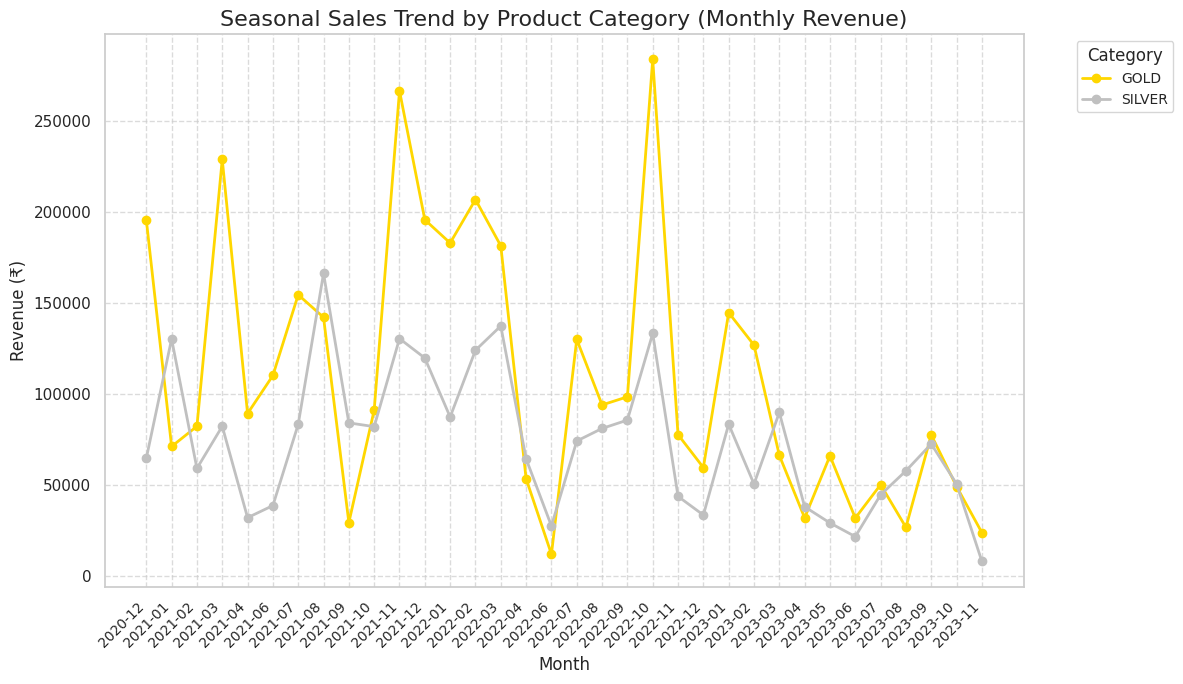

Seasonal Sales Trend by Product Category chart generated.


In [ ]:
# Colab Cell 16: Seasonal Sales Trend by Product Category

# =============================================================================
# 18. Seasonal Sales Trend by Product Category
# =============================================================================
# Group revenue by Month and Category
seasonality_data = sales_df.groupby(['Month', 'Category']).agg(
    Revenue=('Total Amount(₹)', 'sum')).reset_index()

# Ensure chronological sorting for monthly data
seasonality_data['Month_Sort'] = pd.to_datetime(seasonality_data['Month'])
seasonality_data = seasonality_data.sort_values('Month_Sort').drop(columns='Month_Sort')

# Define custom colors for better distinction and branding
custom_colors = {
    'GOLD': '#FFD700',   # Gold color
    'SILVER': '#C0C0C0', # Silver color
    'DIAMOND': '#B9F2FF', # Light blue for diamond
    'PLATINUM': '#E5E4E2', # Platinum grey
    'GEMSTONE': '#8A2BE2' # Blue-violet for gemstones
    # Add other categories if present in your data
}

plt.figure(figsize=(12,7))
for cat in seasonality_data['Category'].unique():
    cat_data = seasonality_data[seasonality_data['Category'] == cat]
    plt.plot(
        cat_data['Month'],
        cat_data['Revenue'],
        marker='o',
        label=cat,
        color=custom_colors.get(cat, 'gray'), # Fallback to gray for unmapped categories
        lw=2 # Line width
    )

plt.title('Seasonal Sales Trend by Product Category (Monthly Revenue)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (₹)', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10) # Place legend outside
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Seasonal Sales Trend by Product Category chart generated.")